In [1]:
import numpy as np
import pymc as pm
import pandas as pd
import arviz as az

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [2]:
csv_fp = "/maps/rt582/coralshift/data/ground_truth/reef_check/reefcheck_data.csv"
data = pd.read_csv(csv_fp)
N = data.shape[0]

# convert days_since_19811231 to datetime
data['date'] = pd.to_datetime('19811231', format='%Y%m%d') + pd.to_timedelta(data['days_since_19811231'], unit='D')
data = data.sort_values('date', ascending=False)
data['coral_cover_Beta'] = (data['Average_coral_cover'] * (N - 1) + 0.5) / N



X_cols = ["lat", "Depth", "Human_pop", "Cyclone", "SST_mean", "SSTA_Mean", "SSTA_min", "SSTA_freqstdev", "SSTA_dhwmax", "TSA_max", "TSA_freqstdev", "Turbidity_mean", "Historical_SST_max"]
# discard any row which contains one or more nan values in any of the rows, X_cols.
data = data.dropna(subset=X_cols)
# keeping only most recent survey for each reef. This eliminates a bit of dirty data for which the ecoregion as assigned as changing over time (South China Sea!)
data = data.drop_duplicates('Reef_ID', keep="first")

predictor_df = data[X_cols]

# normalise (min-max) # TODO: try standard scaling
predictor_df = (predictor_df - predictor_df.min()) / (predictor_df.max() - predictor_df.min())

# site and ecoregion info
sites_and_region_df = pd.DataFrame({
    'Reef_ID': data.Reef_ID.values,
    'Ecoregion': data['Ecoregion'].loc[predictor_df.index.values]
})


# Create dummy data for "diversity" dataframe. # TODO: replace with actual diversity data
num_ecoregions_in_sample = sites_and_region_df.Ecoregion.nunique()

diversity_df = pd.DataFrame({
    'Ecoregion': sites_and_region_df.Ecoregion.unique(),
    'Ecoregion_no': range(0, len(data.Ecoregion.unique())),
    'diversity.standardized': np.random.uniform(0, 1, num_ecoregions_in_sample)
})

# join sites_and_region_df and diversity_df
sites_and_region_df = sites_and_region_df.merge(diversity_df, on='Ecoregion')
print(len(predictor_df))

3024


In [3]:
# number of samples (rows in dataframe)
N = predictor_df.shape[0]
# number of covariants (environmental variables)
K = predictor_df.shape[1]
# Nre: number of sites
# Nre = N # TODO: fix hierarchical component. Currently need to have number of sites the same as the number of samples...
Nre = len(data['Reef_ID'].unique())
# re: site indices
re = data.reset_index().index.values[:Nre]
# Ner: number of ecoregions
Ner = len(data['Ecoregion'].unique())


# Preparing data for beta model
model_Data = {
    'Y': data['coral_cover_Beta'].values,
    'N': N,
    'predictor_df': predictor_df,
    'K': K,
    're': re,
    'Ner': Ner,
    'Nre': Nre,
    # 'region_for_each_site': data['Ecoregion'],  # len: Nre
    'region_for_each_site': sites_and_region_df['Ecoregion_no'],  # len: Nre
    'diversity': diversity_df['diversity.standardized'].values  # len: Ner
}

# PyMC model
with pm.Model(coords={"predictors": predictor_df.columns.values}) as coral_cover_model:
    # 1. SETTING PRIORS
    # 1A. Priors for fixed effects
    # setting Normal beta prior for each predictor
    beta = pm.Normal('beta', mu=0, sigma=0.0001, shape=K, dims="predictors")
    
    # 1B. Global and ecoregion priors
    num_site = pm.Normal('num-site', mu=0, sigma=0.0016)
    denom_site = pm.Normal('denom-site', mu=0, sigma=1)
    sigma_site = pm.Deterministic('sigma-site', abs(num_site / denom_site))
    
    # setting precision parameter (sigma) for ecoregion
    num_ecoregion = pm.Normal('num-ecoregion', mu=0, sigma=0.0016)
    denom_ecoregion = pm.Normal('denom-ecoregion', mu=0, sigma=1)
    sigma_ecoregion = pm.Deterministic('sigma-ecoregion', abs(num_ecoregion / denom_ecoregion))
    # variance across ecoregion
    tau_ecoregion = pm.Deterministic('tau-ecoregion', 1 / (sigma_ecoregion * sigma_ecoregion))

    # 'slope' effect in model
    beta_diversity = pm.Normal('beta-diversity', mu=0, sigma=0.0001)
    
    # g represents hierarchical effect for each ecoregion. Prior depends on global mean, a slope 
    # component 'beta_diversity' and the ecoregion diversity
    g_temp = pm.Normal('g-temp', mu=0, sigma=1, shape=Ner)
    mu_global = pm.Normal('mu-global', mu=0, sigma=0.0001)
    g = pm.Deterministic('g', mu_global + g_temp + beta_diversity*model_Data['diversity'])

    ecoregion = pm.Normal('ecoregion', mu=g, sigma=tau_ecoregion, shape=Ner)
    # 1C. Priors for sites: half-Cauchi(25) for each
    # variance across globe

    tau_site = pm.Deterministic('tau-site', 1 / (sigma_site * sigma_site))
    num_theta_site = pm.Normal('num-theta-site', mu=0, sigma=0.0016)
    denom_theta_site = pm.Normal('denom-theta-site', mu=0, sigma=1)

    # theta is latent model variable used in calculation of beta model
    theta = pm.Deterministic('theta', abs(num_theta_site / denom_theta_site))
    
    # setting Normal prior for each site. Tau is variance for each site
    # Indexing 'ecoregion' based on the corresponding ecoregion index for each site
    mu_a = ecoregion[model_Data['region_for_each_site']]
    a = pm.Normal('a', mu=mu_a, sigma=tau_site, shape=Nre)    # and this

    # 2. LIKELIHOOD
    # beta distribution: latent variable theta, linear predictor pi, and site effect a

    eta = pm.math.dot(predictor_df.values, beta) + a[re.astype(int)]  # I think this is the problem
    pi = pm.Deterministic('pi', pm.math.invlogit(eta))  # shape 101 for some reason. Expect shape ?


    shape1 = theta * pi
    shape2 = theta * (1 - pi)

    Y = pm.Beta('Y-obs', alpha=shape1, beta=shape2, observed=model_Data['Y'])

    ExpY = pi
    VarY = pi * (1 - pi) / (theta + 1)

    # Pearson residuals between observed and new data
    PRes = (Y - ExpY) / pm.math.sqrt(VarY)

    # Discrepancy measures (used for checking overdispersion: https://online.stat.psu.edu/stat504/book/export/html/779#:~:text=Overdispersion%20means%20that%20the%20variance,because%20the%20latter%20is%20greater.)
    YNew = pm.Beta('Y-new', alpha=shape1, beta=shape2, shape=N)
    # Pearson residuals between observed and new data
    PRes_new = (YNew - ExpY) / pm.math.sqrt(VarY)
    
    # square residuals
    D = pm.Deterministic('D', np.power(PRes, 2))
    D_new = pm.Deterministic('D-new', np.power(PRes_new, 2))
    
    # # Fit statistics
    # # Fit = pm.Deterministic('Fit', np.sum(D))
    # # Fit_new = pm.Deterministic('Fit_new', np.sum(D_new))

# Initial values to sample for the distributions (should encapsulate the true values)
inits = {
    'beta': np.random.normal(0, 0.1, K),
    'a': np.random.normal(0, 0.1, Nre),
    'beta_diversity': np.random.normal(0, 0.1),
    'num-site': np.random.normal(0, 25),
    'denom-site': np.random.normal(0, 1),
    'numtheta-site': np.random.normal(0, 25),
    'denom-theta-site': np.random.normal(0, 1),
    'num-ecoregion': np.random.normal(0, 25),
    'denom-ecoregion': np.random.normal(0, 1)
}

# Sampling
with coral_cover_model:
    trace = pm.sample(500, 
    tune=1000,
    # init='advi+adapt_diag', 
    chains=4,
    cores=16,
    random_seed=42,
    nuts={"target_accept": 0.95},
    )

# Print summary of the trace
print(pm.summary(trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 16 jobs)
NUTS: [beta, num-site, denom-site, num-ecoregion, denom-ecoregion, beta-diversity, g-temp, mu-global, ecoregion, num-theta-site, denom-theta-site, a, Y-new]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1464 seconds.
There were 308 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[lat]        0.000  0.000    -0.0    0.000      0.000    0.000    1260.0   
beta[Depth]     -0.000  0.000    -0.0    0.000      0.000    0.000      20.0   
beta[Human_pop] -0.000  0.000    -0.0    0.000      0.000    0.000    1419.0   
beta[Cyclone]    0.000  0.000    -0.0    0.000      0.000    0.000    1233.0   
beta[SST_mean]  -0.000  0.000    -0.0    0.000      0.000    0.000      40.0   
...                ...    ...     ...      ...        ...      ...       ...   
D-new[3019]      0.887  1.302     0.0    3.158      0.068    0.048     815.0   
D-new[3020]      0.914  1.455     0.0    3.344      0.126    0.089      22.0   
D-new[3021]      0.980  1.171     0.0    3.031      0.037    0.027     833.0   
D-new[3022]      1.370  1.561     0.0    3.632      0.384    0.277      22.0   
D-new[3023]      0.968  1.443     0.0    3.415      0.118    0.084     204.0   

                 ess_tail  r_hat  
beta

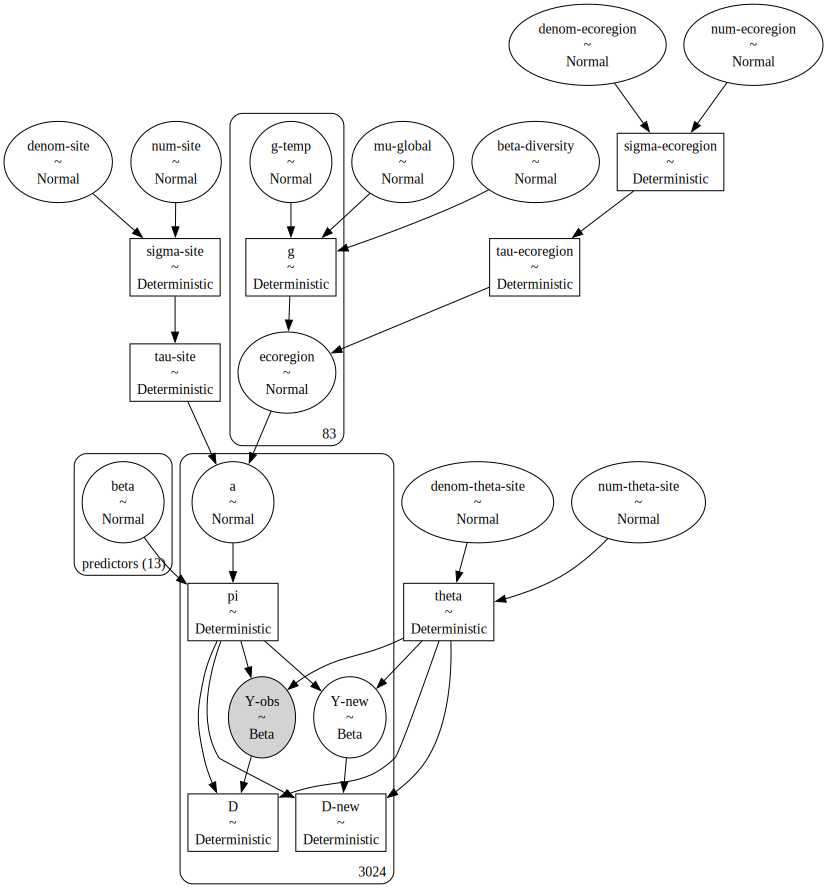

In [4]:
pm.model_to_graphviz(coral_cover_model)

array([[<Axes: title={'center': 'sigma-site'}>,
        <Axes: title={'center': 'sigma-site'}>],
       [<Axes: title={'center': 'sigma-ecoregion'}>,
        <Axes: title={'center': 'sigma-ecoregion'}>]], dtype=object)

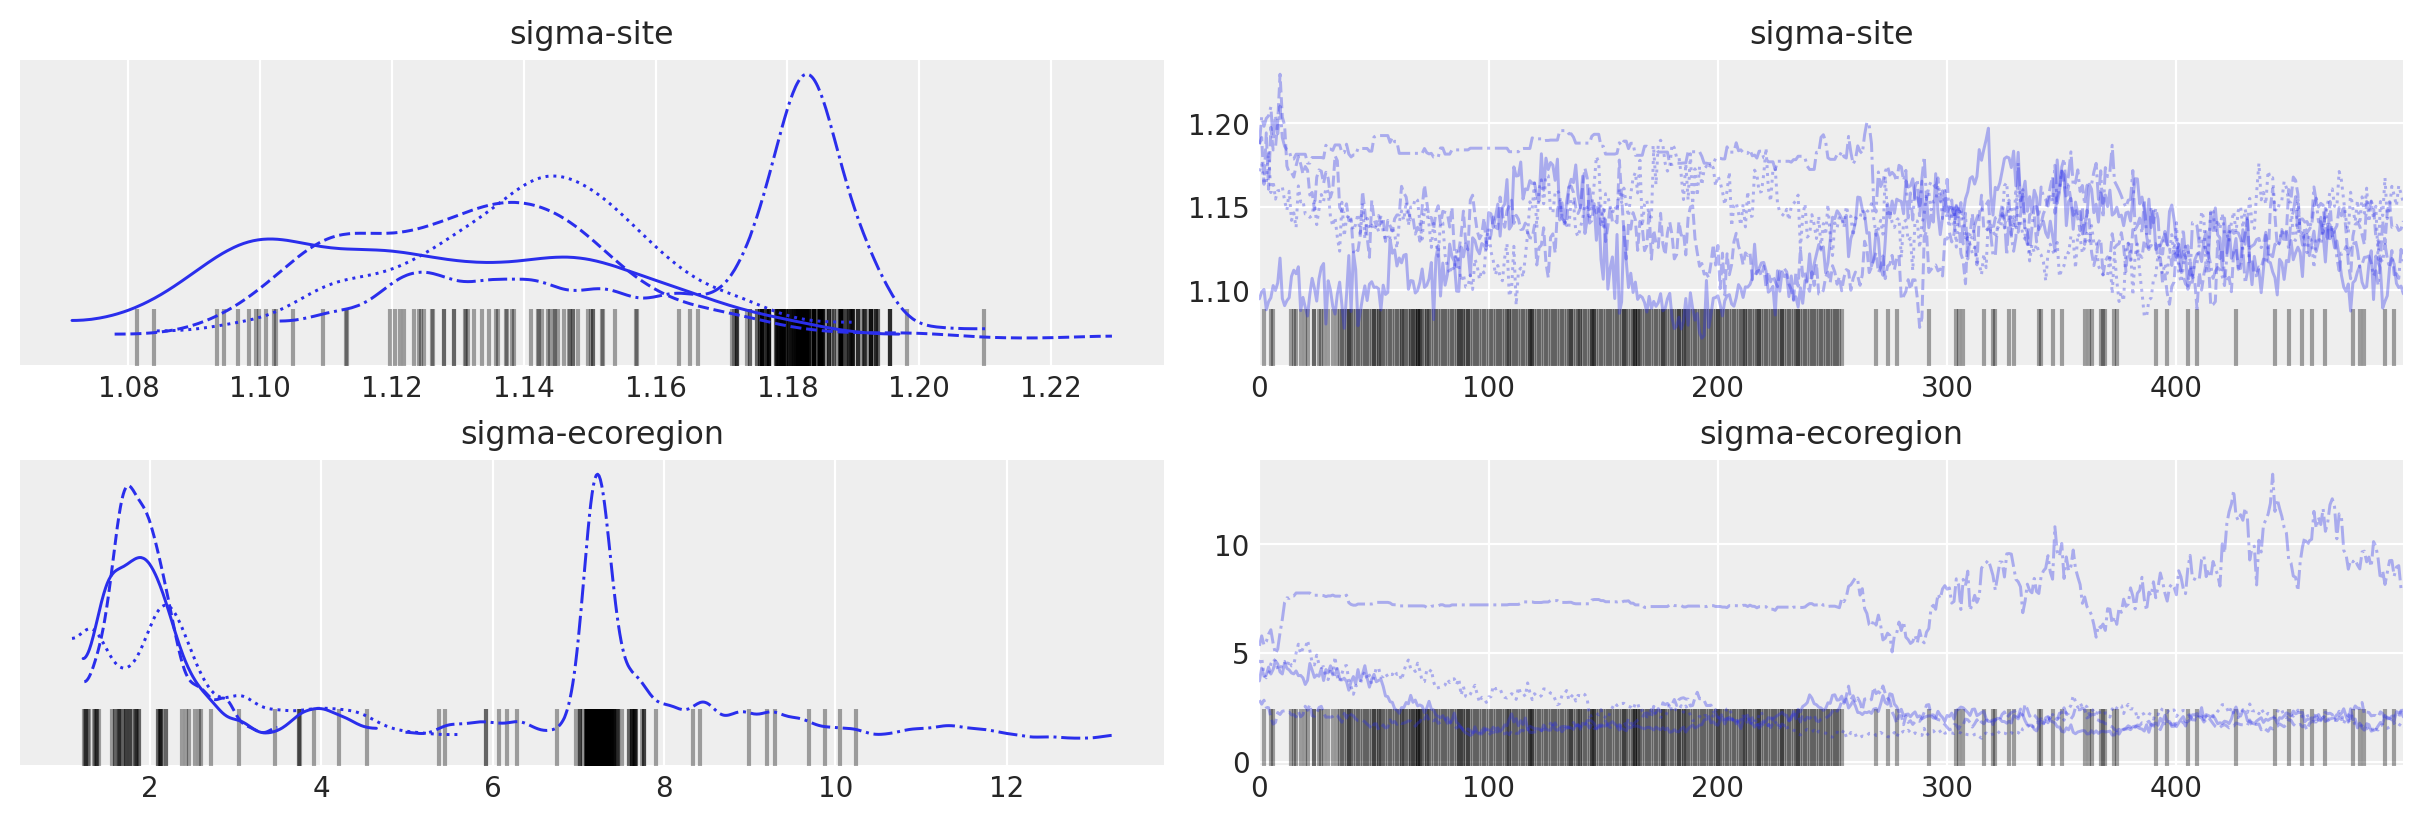

In [5]:
az.plot_trace(trace, var_names=["sigma-site","sigma-ecoregion"])

In [ ]:
az.plot_energy(trace)

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

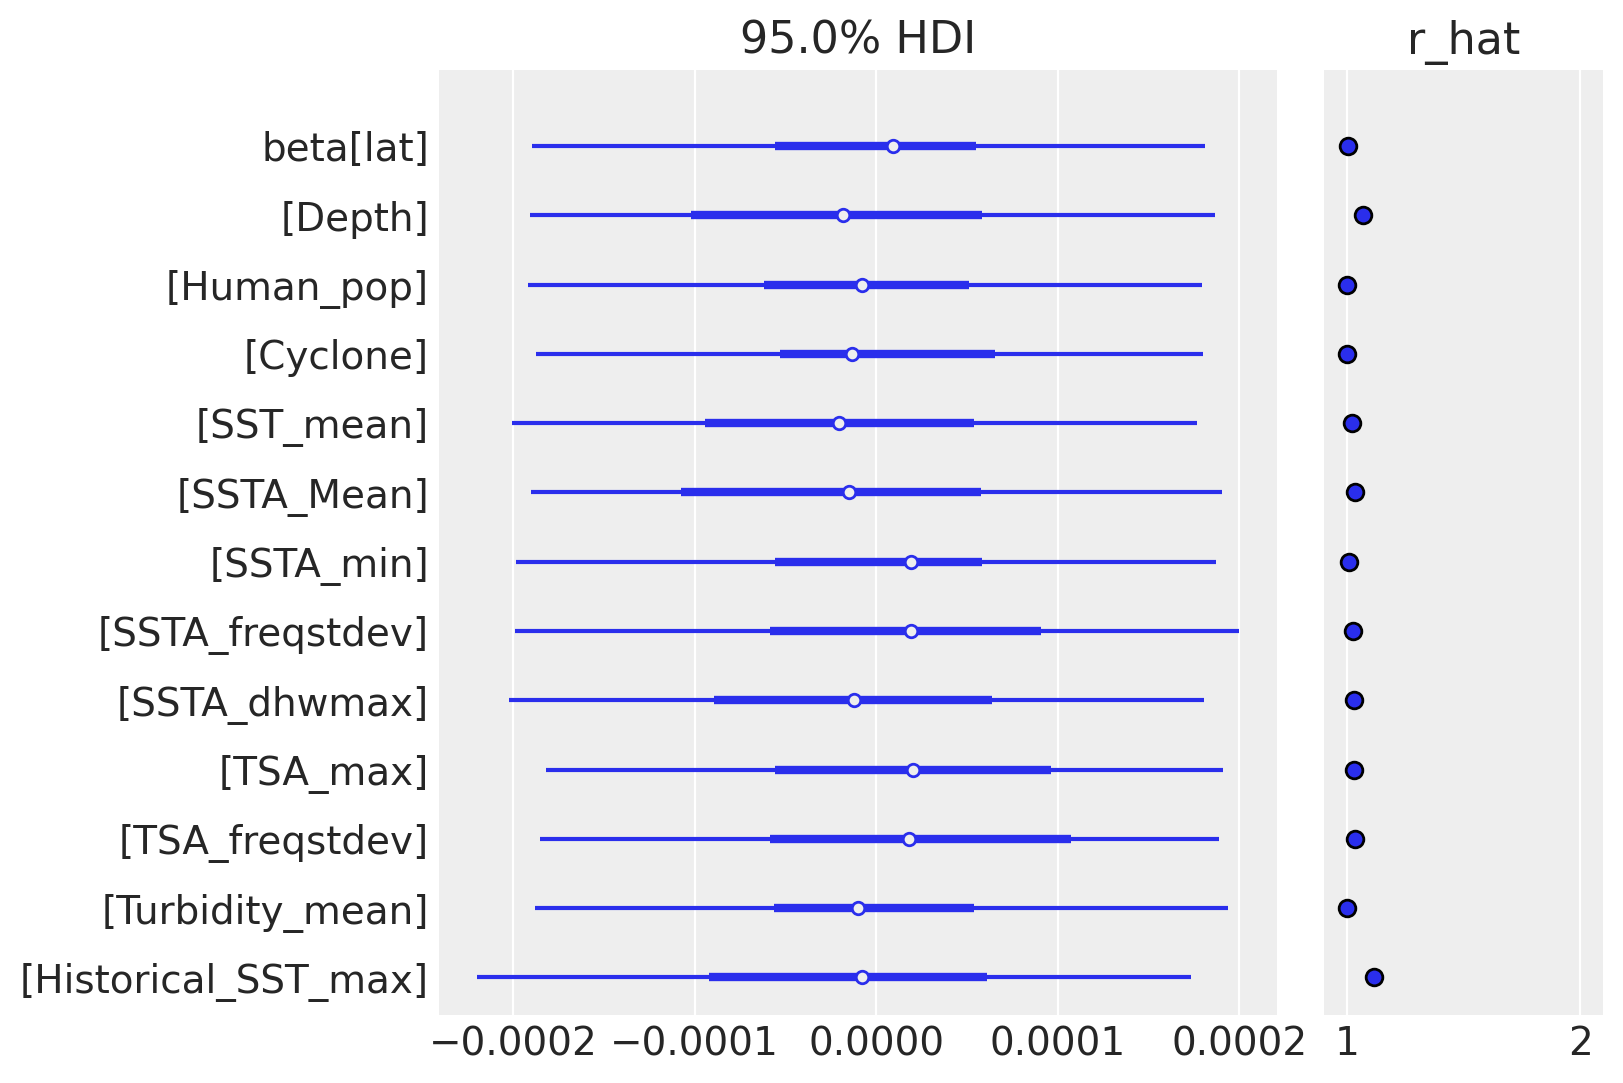

In [6]:
az.plot_forest(trace, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True)